In [1]:
from correlation import getGainAndACamp, get_num_electrons
import h5py, matplotlib, glob, os
import matplotlib.pyplot as plt
from bead_util import xi, drive, time_ordered_file_list
import numpy as np
import correlation_steps as corrsteps
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm

# Inputs
NFFT = 2 ** 17
distance_between_plates = 0.001 # meters

In [2]:
def get_pressure_from_name(fname):
    i = fname.rfind('/')
    j = fname.rfind('mbar')
    if j<0:return 0
    else:
        pstr = fname[i+1:j]
        k = pstr.find('_')
        if k<0:return float(pstr)
        else:
            pstr = pstr.replace('_', '.')
            return float(pstr)
def get_pressure(fname, ps):
    p = ps[0]
    return max(p, get_pressure_from_name(fname))

In [3]:
NFFT = 2 ** 17
def getdata(fname):
    gain, ACamp = getGainAndACamp(fname, need_ACamp=False)
    f = h5py.File(fname, 'r')
    dset = f['beads/data/pos_data']
    dat = np.transpose(dset)
    Fs = dset.attrs['Fsamp']
    pressure = get_pressure(fname, dset.attrs['temps'])
    dat = dat * 10. / (2 ** 15 - 1.)
    #drive_data = dat[:, drive] - np.mean(dat[:, drive])
    #normalized_drive = drive_data / np.std(drive_data)
    #drivepsd, freqs = matplotlib.mlab.psd(normalized_drive, Fs=Fs, NFFT=NFFT)
    x = (dat[:, xi] - np.mean(dat[:, xi]))/gain
    xpsd, freqs = matplotlib.mlab.psd(x/float(len(x)), Fs=Fs, NFFT=NFFT)
    #return freqs, xpsd, drivepsd, pressure # Hz, V^2/Hz, s, mbar
    return freqs, xpsd, pressure # Hz, V^2/Hz, mbar

In [22]:
def get_squared_area_and_pressure(f):
    freqs, xpsd, p = getdata(f) # Hz, V/sqrtHz, 1/sqrtHz
    start_index = np.argmin(np.abs(freqs - 40.))
    end_index = np.argmin(np.abs(freqs - 50.))
    binF = freqs[1]-freqs[0]
    xpsd_values = sorted(xpsd[start_index:end_index])
    squared_area = binF*sum(xpsd_values[:len(xpsd_values)/10]) # V^2
    return squared_area, p

In [23]:
def getConstant(calib_path):
    """ normalization to units of electrons """
    calibration_list = time_ordered_file_list(calib_path)
    i = min(len(calibration_list), 5)
    square_areas = []
    for f in calibration_list[:i]:
        sarea, p = get_squared_area_and_pressure(f)
        square_areas.append(sarea)
    area = np.sqrt(np.average(square_areas))
    return area*num_electrons_in_sphere # V/electron

In [24]:
def get_noise(file_list):
    """ returns theta and ratio of [response at 2f] and [drive at f] """
    pressures, areas = ([] for i in range(2))
    for f in file_list:
        sarea, p = get_squared_area_and_pressure(f)
        pressures.append(p) # mbar
        areas.append(np.sqrt(sarea)) # V/sqrtHz
    return pressures, np.array(areas) # mbar, V/sqrtHz

In [25]:
# go through 1, 4, 5, and 8
calib1 = "/data/20170726/bead1_15um_QWP/calibration_1positive_47_3Hz/"
path1 = "/data/20170726/bead1_15um_QWP/"
diameter1 = 16.78 # micron

calib4 = "/data/20170726/bead4_15um_QWP/calibration_47_3Hz/"
path4 = "/data/20170726/bead4_15um_QWP/"
diameter4 = 16.18 # micron

calib5 = calib1
path5 = "/data/20170726/bead5_15um_QWP/"
diameter5 = 16.48 # micron (APPROXIMATELY)

calib8 = "/data/20170726/bead8_15um_QWP/calibration_1positive/"
path8 = "/data/20170726/bead8_15um_QWP/"
diameter8 = 16.38 # micron

calibs = [calib1, calib4, calib5, calib8]
paths = [path1, path4, path5, path8]
diameters = [diameter1, diameter4, diameter5, diameter8]

In [28]:
getConstant(calib8)

13975.731335613807

In [26]:
def get_bead_name(path):
    i = path.find('bead')
    j = path.find('_', i)
    return path[i:j]

<IPython.core.display.Javascript object>


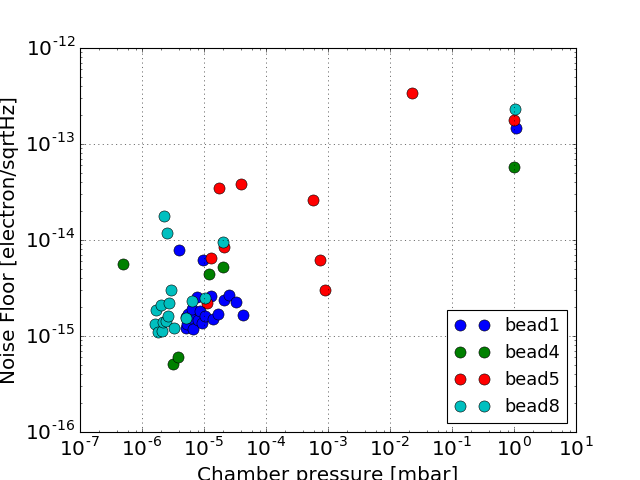

In [27]:
import matplotlib
%matplotlib notebook

for calib, path, diameter in zip(calibs, paths, diameters):
    # do a full plot
    num_electrons_in_sphere = get_num_electrons(diameter)

    file_list = glob.glob(os.path.join(path, '*_att.h5'))
    file_list.sort(key=os.path.getmtime)
    c = getConstant(calib) # V/electron

    pressures, areas = get_noise(file_list) # V/sqrtHz
    pressures, areas = zip(*sorted(zip(pressures, areas)))
    pressures = pressures[:-1]
    areas = areas[:-1]

    plt.loglog(pressures, areas/c, 'o', markersize=10, label=get_bead_name(path)) # mbar, electron/sqrt(Hz)

matplotlib.rcParams.update({'font.size': 18})

plt.xlabel('Chamber pressure [mbar]')
plt.ylabel('Noise Floor [electron/sqrtHz]')
plt.legend(prop={'size': 16}, loc=4)

plt.grid()
plt.show()